In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import seaborn as sns
import math

import datetime


import random
from collections import deque

plt.style.use('ggplot')

import sys 
sys.path.append('..')


In [174]:
df = pd.read_csv("../data/ChargePoint Data CY20Q4_fixed_dates.csv", index_col=0)
df = df[df['End Date'] >= '2017-01-01']
df_webster = df[df.Cluster == 'WEBSTER']

pred_webster = pd.read_csv('../predictions/best_sweep_tgcn_dynamic_2/predictions_TGCN_WEBSTER_trim-shape-30_2.csv', index_col=0)

pred_webster = pred_webster.iloc[:2831]
pred_webster = pred_webster.reset_index(drop=False)

In [19]:

def add_time_columns(df_in, date_name = 'Start Date'):
    df_out = df_in.copy()
    df_out['Start Date Rounded'] = df_out[date_name].apply(lambda x: pd.to_datetime(x).round('30min'))
    df_out['DayOfWeek'] = df_out[date_name].apply(lambda x: pd.to_datetime(x).dayofweek)

    df_out['Hour'] = df_out['Start Date Rounded'].apply(lambda x: pd.to_datetime(x).hour)
    df_out['Minute'] = df_out['Start Date Rounded'].apply(lambda x: pd.to_datetime(x).minute)
    df_out['HourMinute'] = df_out['Hour'].astype(str) + ':' + df_out['Minute'].astype(str)

    df_out = df_out.drop(columns = 'Start Date Rounded')
    #df_out['HourMinute'] = pd.to_datetime(df_out['HourMinute'].dt.round('30min'))

    return df_out


df_webster = add_time_columns(df_webster)
pred_webster = add_time_columns(pred_webster, date_name='Date')

In [21]:
## Extract arrival rates from predictions
pred_webster['ArrivalRate'] = pred_webster['WEBSTER_1_pred'].diff(periods=1)
pred_webster = pred_webster.fillna(0)
pred_webster.loc[(pred_webster['ArrivalRate'] < 0), 'ArrivalRate'] = 0 

## Convert service time to hour 
df_webster['Total Duration (hour)'] = df_webster['Total Duration (min)'] / 60

<AxesSubplot:xlabel='Hour', ylabel='Total Duration (min)'>

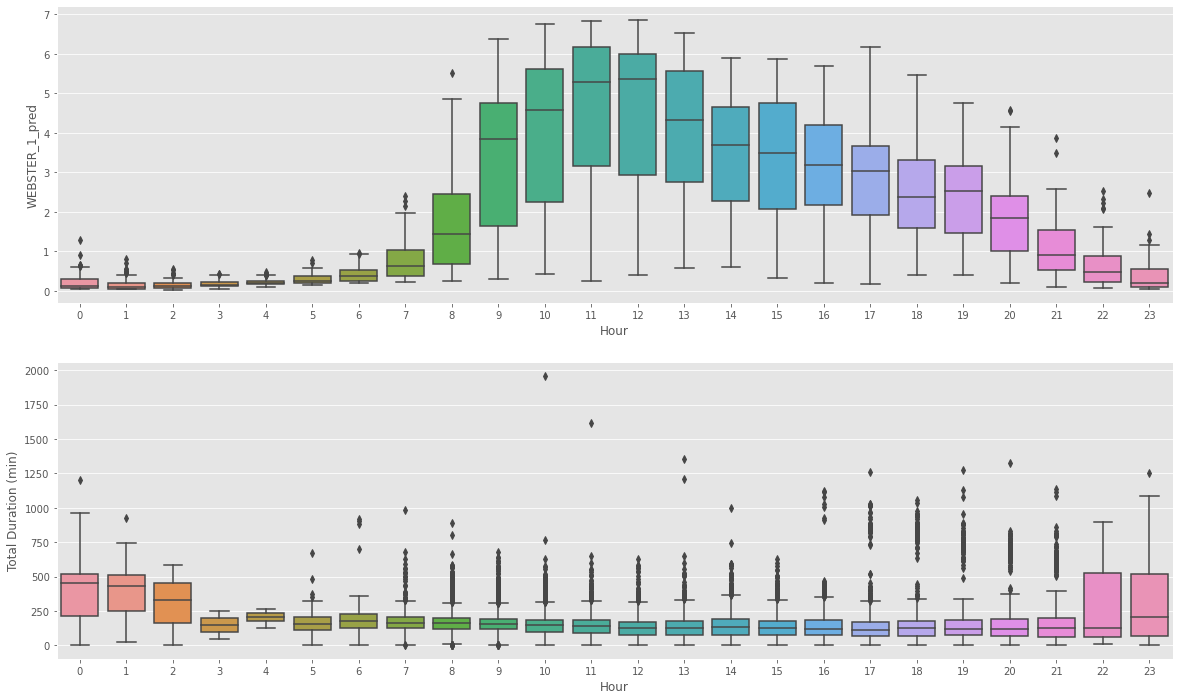

In [28]:
fig, axes = plt.subplots(2, figsize=(20,12))
sns.boxplot(data=pred_webster, x="Hour", y="WEBSTER_1_pred", ax = axes[0])
sns.boxplot(data=df_webster, x="Hour", y="Total Duration (min)", ax = axes[1])


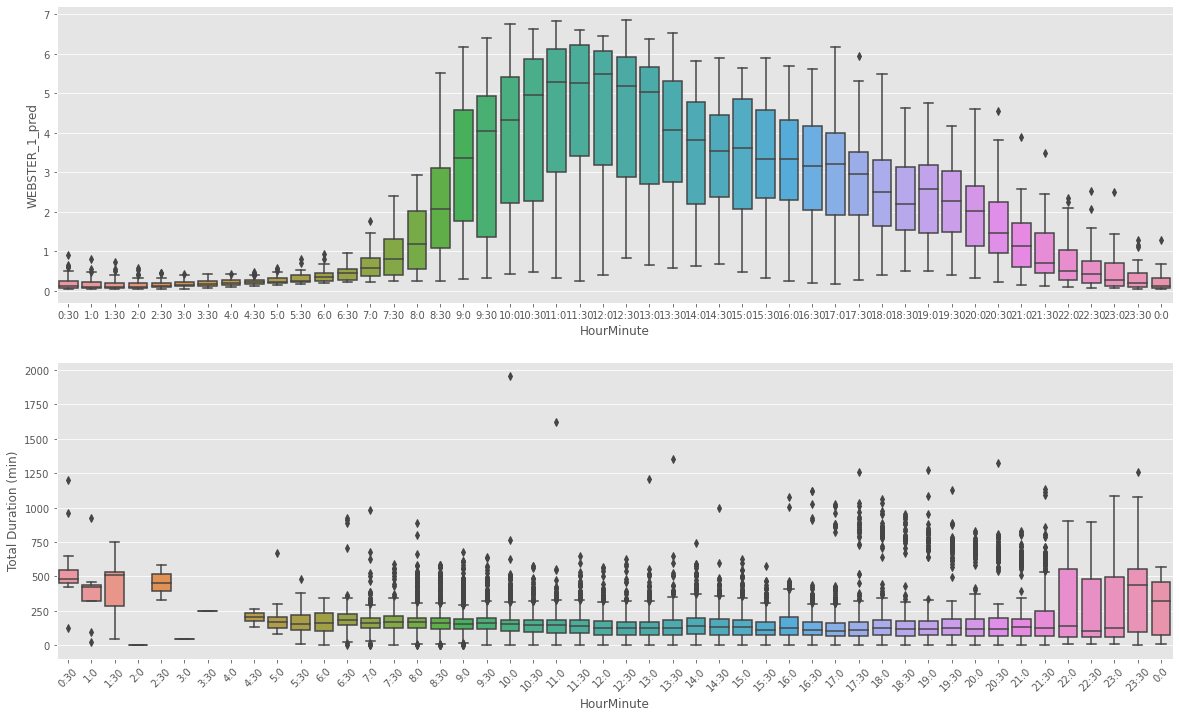

In [40]:
fig, axes = plt.subplots(2, figsize=(20,12))
sns.boxplot(data=pred_webster, x="HourMinute", y="WEBSTER_1_pred", ax = axes[0])
sns.boxplot(data=df_webster, x="HourMinute", y="Total Duration (min)", ax = axes[1], order=pred_webster['HourMinute'].unique())
plt.xticks(rotation=45)
plt.show()

In [41]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt

cluster_name = 'WEBSTER'
day_of_week_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']



def plot_histogram_hour(hour, day_of_week):
    fig, axs = plt.subplots(figsize=(12, 8))
    time_specific_df = pred_webster[(pred_webster['DayOfWeek'] == day_of_week) & (pred_webster['Hour'] == hour)]
    bins = range(0, int(time_specific_df[cluster_name + '_1_pred' ].max()) + 2)
    axs.hist(time_specific_df[cluster_name + '_1_pred'], density=True, edgecolor='black', linewidth=1.2, bins=list(bins))
    # make x axis integer
    axs.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs.set_title(f'Predidctions on {day_of_week_list[day_of_week]} {hour}')
    plt.show()

hour_intervals = list(range(24))# [f'{hour:1d}' for hour in range(24)]
hour_widget = widgets.SelectionSlider(
    options=hour_intervals,
    value=0,
    description='Hour:',
    disabled=False,
    continuous_update=True,
)

day_of_week_intervals = list(range(7))
day_of_week_widget = widgets.SelectionSlider(
    options=day_of_week_intervals,
    value=0,
    description='Day of week:',
    disabled=False,
    continuous_update=True,
)

widgets.interact(plot_histogram_hour, hour=hour_widget, day_of_week=day_of_week_widget)

interactive(children=(SelectionSlider(description='Hour:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

<function __main__.plot_histogram_hour(hour, day_of_week)>

In [53]:
webster_hourly_pluginTime = df_webster.groupby('Hour').mean()
webster_hourly_pluginTime = webster_hourly_pluginTime.reset_index(drop=False)[['Hour', 'Total Duration (min)', 'Total Duration (hour)']]
webster_hourly_pluginTime = webster_hourly_pluginTime.rename(columns={'Total Duration (min)': 'AverageDuration (min)', 'Total Duration (hour)': 'Average Duration (hour)'})

webster_hourly_prediction = pred_webster.groupby('Hour').mean()
webster_hourly_prediction = webster_hourly_prediction.reset_index(drop=False)[['Hour', 'WEBSTER_1_pred', 'ArrivalRate']]
webster_hourly_prediction = webster_hourly_prediction.rename(columns={'WEBSTER_1_pred': 'AveragePrediction', 'ArrivalRate': 'AverageArrivalRate'})


In [54]:
webster_half_hourly_pluginTime = df_webster.groupby('HourMinute').mean()
webster_half_hourly_pluginTime = webster_half_hourly_pluginTime.reset_index(drop=False)[['HourMinute', 'Total Duration (min)', 'Total Duration (hour)']]
webster_half_hourly_pluginTime = webster_half_hourly_pluginTime.rename(columns={'Total Duration (min)': 'AverageDuration (min)', 'Total Duration (hour)': 'Average Duration (hour)'})

webster_half_hourly_prediction = pred_webster.groupby('HourMinute').mean()
webster_half_hourly_prediction = webster_half_hourly_prediction.reset_index(drop=False)[['HourMinute', 'WEBSTER_1_pred', 'ArrivalRate']]
webster_half_hourly_prediction = webster_half_hourly_prediction.rename(columns={'WEBSTER_1_pred': 'AveragePrediction', 'ArrivalRate': 'AverageArrivalRate'})

#### Apply to queue

#### Queue estimating length with our predictions and waiting times as mean service time

In [ ]:
## Try to run below

In [ ]:
def queue_length_wait_times(df_prediction, df_observed, cluster = 'WEBSTER', time_resolution = 'HourMinute', no_of_plugs = 4):

    ## Create arrival rate column
    df_prediction['ArrivalRate'] = df_prediction['WEBSTER_1_pred'].diff(periods=1)
    df_prediction = df_prediction.fillna(0)
    df_prediction.loc[(df_prediction['ArrivalRate'] < 0), 'ArrivalRate'] = 0 

    ## Aggerate waiting times 
    df_pluginTime = df_observed.groupby(time_resolution).mean()
    df_pluginTime = df_pluginTime.reset_index(drop=False)[[time_resolution, 'Total Duration (min)', 'Total Duration (hour)']]
    df_pluginTime = df_pluginTime.rename(columns={'Total Duration (min)': 'AverageDuration (min)', 'Total Duration (hour)': 'Average Duration (hour)'})

    
    ## Add queue length 
    df_prediction['QueueLength'] = np.zeros(len(df_prediction))
    df_prediction.loc[(df_prediction[cluster + '_1_pred'] >= 4), 'QueueLength'] = (df_prediction[cluster + '_1_pred'] - no_of_plugs)


    ## Merge predictions and waiting times

    df_prediction_Wtime = df_prediction_Wtime.merge(
        df_pluginTime,
        how="left",
        on = time_resolution)

    df_prediction_Wtime['WaitingTime'] = np.zeros(len(df_prediction_Wtime))
    df_prediction_Wtime.loc[(df_prediction_Wtime['QueueLength']!= 0), 'WaitingTime'] = (df_prediction_Wtime['QueueLength']*df_prediction_Wtime['AverageDuration (min)'] )

    return df_prediction_Wtime


In [57]:
webster_hourly_pluginTime['AverageDuration (hour)'] = webster_hourly_pluginTime['AverageDuration (min)'] / 60
webster_half_hourly_pluginTime['AverageDuration (hour)'] = webster_half_hourly_pluginTime['AverageDuration (min)'] / 60

In [58]:
## Add queue length
pred_webster['QueueLength'] = np.zeros(len(pred_webster))
pred_webster.loc[(pred_webster['WEBSTER_1_pred'] >= 4), 'QueueLength'] = (pred_webster['WEBSTER_1_pred'] - 4)

## For hourly aggregated
webster_hourly_prediction['QueueLength'] = np.zeros(len(webster_hourly_prediction))
webster_hourly_prediction.loc[(webster_hourly_prediction['AveragePrediction'] >= 4), 'QueueLength'] = (webster_hourly_prediction['AveragePrediction'] - 4)


In [59]:
## Add queue length
pred_webster['QueueLength'] = np.zeros(len(pred_webster))
pred_webster.loc[(pred_webster['WEBSTER_1_pred'] >= 4), 'QueueLength'] = (pred_webster['WEBSTER_1_pred'] - 4)

## For hourly aggregated
webster_hourly_prediction['QueueLength'] = np.zeros(len(webster_hourly_prediction))
webster_hourly_prediction.loc[(webster_hourly_prediction['AveragePrediction'] >= 4), 'QueueLength'] = (webster_hourly_prediction['AveragePrediction'] - 4)

In [60]:
merged_webster = pred_webster.merge(
    webster_half_hourly_pluginTime,
    how="left",
    on = 'HourMinute')

merged_webster['WaitingTime'] = np.zeros(len(merged_webster))
merged_webster.loc[(merged_webster['QueueLength']!= 0), 'WaitingTime'] = (merged_webster['QueueLength']*merged_webster['AverageDuration (min)'] )


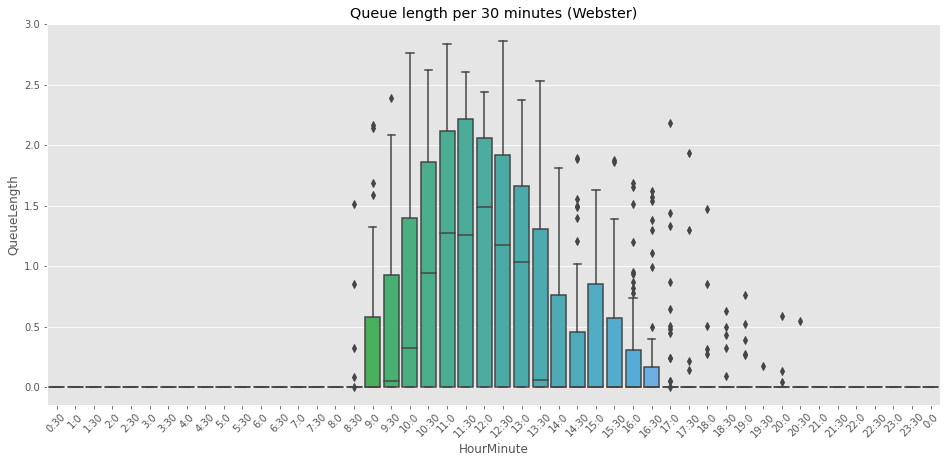

In [106]:
fig, axes = plt.subplots(1, figsize=(16,7), sharex=True)
axes.set_title('Queue length per 30 minutes (Webster)')
sns.boxplot(data=merged_webster, x="HourMinute", y="QueueLength", ax = axes)
plt.xticks(rotation=45)
#ax2 = plt.twinx()
#sns.boxplot(data=merged_webster, x = 'HourMinute', y = 'WaitingTime', ax = ax2)
plt.show()


##### Below is an attempt to use queuing theory (poisson arrival, exponential service times)

In [ ]:
def mmc_queue_hour(lambd, mu, c, time_horizon, seed=None):
    ## Function to simulate an hour 

    random.seed(seed)  # Set seed for reproducibility

    ## use predictions and observed service times to sample from

    ## sample arrival times

    # interarrival_times = np.random.poisson(lambd, num_customers)
    arrivals = np.random.poisson(lambd, time_horizon)

    ## sample service times
    service_times = np.random.exponential(1/mu, time_horizon)

    #print(service_times)
    #arrival_times = np.cumsum(interarrival_times)
    departure_times = np.zeros(time_horizon)

    queue_length = []

    queue = []  # Create an empty queue
    completed_customers = []
    rejected_customers = 0

    for i in range(time_horizon):
        queue_length.append(len(queue))
        
        for k in range(len(queue)):
            if (queue[k] < i):
                queue.pop()
        
        # If a customer arrives at time i,
        if (arrivals[i] > 0):
            if len(queue) < c:
                departure_time = i + service_times[i]
                queue.append(departure_time)

                # keep lowest depature time first
                queue.sort(reverse=True)

            else:
                rejected_customers += 1
        
            completed_customers.append((i, departure_time))

    return completed_customers, queue_length, rejected_customers

        

In [302]:
def mmc_queue_day(df_sessions, c, time_horizon, seed=None, hour = False, time_resolution = 'HourMinute'):
    random.seed(seed)  # Set seed for reproducibility

    ## choose arrival and service rates
    arrivals = []
    arrivals_true = []
    service_times = []
    for i in merged_webster[time_resolution].unique():
        lambd = np.random.choice(df_sessions[df_sessions[time_resolution] == i]['ArrivalRate'])
        lambd_true = np.random.choice(df_sessions[df_sessions[time_resolution] == i]['TrueArrivalRate'])
        mu = np.random.choice(1/df_sessions[df_sessions[time_resolution] == i]['AverageDuration (min)'])
        
        arrivals.append(np.random.poisson(lambd, 1))
        arrivals_true.append(np.random.poisson(lambd_true, 1))
        service_times.append(np.random.exponential(1/mu, 1))


    arrivals = [item for sublist in arrivals for item in sublist]
    arrivals_true = [item for sublist in arrivals_true for item in sublist]
    service_times = [item for sublist in service_times for item in sublist]

    service_times = [0 if math.isnan(x) else x for x in service_times]

    
    departure_times = np.zeros(time_horizon)
    departure_times_true = np.zeros(time_horizon)

    queue_length = []
    queue_length_true = []

    queue = []  # Create an empty queue
    queue_true = []

    completed_customers = []
    completed_customers_true = []

    rejected_customers = 0
    rejected_customers_true = 0

    for i in range(time_horizon):
        queue_length.append(len(queue))
        queue_length_true.append(len(queue))
        
        k = len(queue) - 1
        while k >= 0:
            if queue[k] < i:
                queue.pop(k)
            k -= 1
        
        t = len(queue_true) - 1
        while t >= 0:
            if queue_true[t] < i:
                queue_true.pop(t)
            t -= 1

        # If a customer arrives at time i,
        if (arrivals[i] > 0):
            if len(queue) < c:
                departure_time = i + service_times[i]
                queue.append(departure_time)

                # keep lowest depature time first
                queue.sort(reverse=True)

            else:
                rejected_customers += 1
        
            completed_customers.append((i, departure_time))
        
        if (arrivals_true[i] > 0):
            if len(queue_true) < c:
                departure_times_true = i + service_times[i]
                queue_true.append(departure_times_true)

                # keep lowest depature time first
                queue_true.sort(reverse=True)

            else:
                rejected_customers_true += 1
        
            completed_customers_true.append((i, departure_times_true))

    return completed_customers, queue_length, rejected_customers, rejected_customers_true

Rejected  0 customers during a simulated day


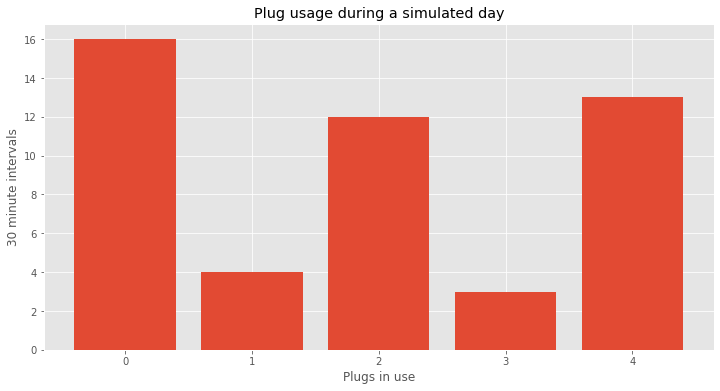

In [86]:
# Example usage
#hour_index = 20
#lambd =  webster_hourly_prediction.iloc[hour_index]['ArrivalRate']  # arrival time np.random.choice(webster_hourly_pluginTime, 1)[0]
#mu =  1 / (webster_hourly_pluginTime.iloc[hour_index]['Total Duration (min)']) # service time  np.random.choice(webster_hourly_pluginTime, 1)[0]  

c = 4  # Number of servers
sim_time = 48 # Number of minutes to simulate

completed_customers, queue_length, rejects = mmc_queue_day(merged_webster, c, sim_time, hour=True)


# print('Rejected % i customers due to insuffient plugs from %ih and %i minutes ahead' % (rejects, hour_index, sim_time) )
print('Rejected % i customers during a simulated day' % (rejects) )


bins = np.arange(min(queue_length), max(queue_length) + 2) - 0.5

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(queue_length, bins = bins, align='mid', rwidth=0.8)
ax.set_title('Plug usage during a simulated day')
ax.set_xlabel('Plugs in use')
ax.set_ylabel('30 minute intervals')
ax.set_xticks(range(int(min(queue_length)), int(max(queue_length) + 1)))
plt.show()

In [95]:

no_simulations = 1000
c = 6  # Number of servers
sim_time = 48 # Number of minutes to simulate
reject_list = []
reject_list_true = []

for i in range(no_simulations):
    completed_customers, queue_length, rejects, rejects_true = mmc_queue_day(merged_webster, c, sim_time, hour=True)
    reject_list.append(rejects)
    reject_list_true.append(rejects_true)


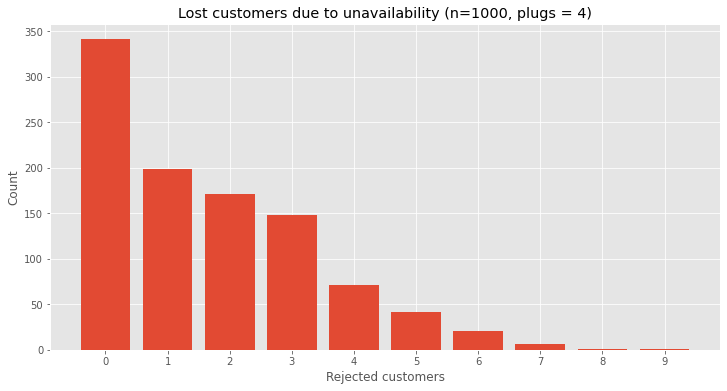

In [94]:
reject_list_c4 = reject_list

bins = np.arange(min(reject_list), max(reject_list) + 2) - 0.5

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(reject_list, bins = bins, align='mid', rwidth=0.8)
ax.set_title('Lost customers due to unavailability (n=1000, plugs = 4)')
ax.set_xlabel('Rejected customers')
ax.set_ylabel('Count')
ax.set_xticks(range(int(min(reject_list)), int(max(reject_list) + 1)))
plt.show()

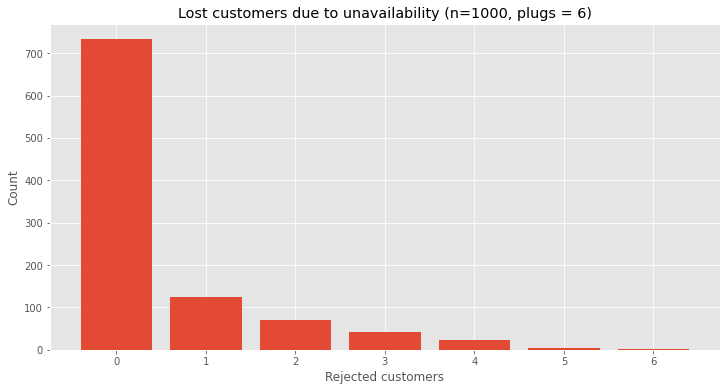

In [96]:
bins = np.arange(min(reject_list), max(reject_list) + 2) - 0.5

fig, ax = plt.subplots(figsize=(12,6))
ax.hist(reject_list, bins = bins, align='mid', rwidth=0.8)
ax.set_title('Lost customers due to unavailability (n=1000, plugs = 6)')
ax.set_xlabel('Rejected customers')
ax.set_ylabel('Count')
ax.set_xticks(range(int(min(reject_list)), int(max(reject_list) + 1)))
plt.show()

### All clusters

In [224]:
def queue_length_wait_times(path, cluster, time_resolution = 'HourMinute', no_of_plugs = 4):

    df_model = pd.read_csv(path, index_col=0)
    df_model = df_model.iloc[:2831]

    ## Add time columns
    df_prediction = add_time_columns(df_model, date_name='Date')
    
    df_observed = pd.read_csv("../data/ChargePoint Data CY20Q4_fixed_dates.csv", index_col=0)
    df_observed = df_observed[df_observed['End Date'] >= '2017-01-01']
    df_observed = df[df.Cluster == cluster]

    df_observed = add_time_columns(df_observed)

    ## Create arrival rate column
    df_prediction['ArrivalRate'] = df_prediction[cluster + '_1_pred'].diff(periods=1)
    df_prediction['TrueArrivalRate'] = df_prediction[cluster + '_1_true'].diff(periods=1)
    df_prediction = df_prediction.fillna(0)

    df_prediction.loc[(df_prediction['ArrivalRate'] < 0), 'ArrivalRate'] = 0 
    df_prediction.loc[(df_prediction['TrueArrivalRate'] < 0), 'TrueArrivalRate'] = 0 

    ## Aggerate waiting times 
    df_pluginTime = df_observed.groupby(time_resolution).mean()
    df_pluginTime = df_pluginTime.reset_index(drop=False)[[time_resolution, 'Total Duration (min)']]
    df_pluginTime = df_pluginTime.rename(columns={'Total Duration (min)': 'AverageDuration (min)'})

    
    ## Add queue length 
    df_prediction['QueueLength'] = np.zeros(len(df_prediction))
    df_prediction['TrueQueueLength'] = np.zeros(len(df_prediction))
    df_prediction.loc[(df_prediction[cluster + '_1_pred'] >= no_of_plugs), 'QueueLength'] = (df_prediction[cluster + '_1_pred'] - no_of_plugs)
    df_prediction.loc[(df_prediction[cluster + '_1_true'] >= no_of_plugs), 'TrueQueueLength'] = (df_prediction[cluster + '_1_true'] - no_of_plugs)


    ## Merge predictions and waiting times

    df_prediction_Wtime = df_prediction.merge(
        df_pluginTime,
        how="left",
        on = time_resolution)

    df_prediction_Wtime['WaitingTime'] = np.zeros(len(df_prediction_Wtime))
    df_prediction_Wtime['TrueWaitingTime'] = np.zeros(len(df_prediction_Wtime))
    df_prediction_Wtime.loc[(df_prediction_Wtime['QueueLength']!= 0), 'WaitingTime'] = (df_prediction_Wtime['QueueLength']*df_prediction_Wtime['AverageDuration (min)'] )
    df_prediction_Wtime.loc[(df_prediction_Wtime['TrueQueueLength']!= 0), 'TrueWaitingTime'] = (df_prediction_Wtime['TrueQueueLength']*df_prediction_Wtime['AverageDuration (min)'] )

    return df_prediction_Wtime

In [ ]:
## Needed to load
run_name = '4favk84f_3'
folder_name = 'forecast_1_aware_tgcn_static_3/'
cluster_names = ['BRYANT', 'CAMBRIDGE', 'HAMILTON', 'HIGH', 'MPL', 'RINCONADA', 'TED', 'WEBSTER']

cluster_list = ['predictions_TGCN_BRYANT_' + run_name, 'predictions_TGCN_CAMBRIDGE_' + run_name, 
                'predictions_TGCN_HAMILTON_' + run_name, 'predictions_TGCN_HIGH_' + run_name, 
                'predictions_TGCN_MPL_' + run_name, 'predictions_TGCN_RINCONADA_' + run_name,
                'predictions_TGCN_TED_' + run_name, 'predictions_TGCN_WEBSTER_' + run_name]

In [303]:
def simulate_all_clusters(no_of_simulations, number_of_servers, simulation_time):
    no_simulations = no_of_simulations
    c = number_of_servers
    sim_time = simulation_time

    df_sim_clusters = pd.DataFrame()
    df_sim_table = pd.DataFrame()

    k = 0

    for i in cluster_list:
        cl_name = cluster_names[k]
        reject_list = []
        reject_list_true = []

        print(cl_name)
        path = '../predictions/' + folder_name + i + '.csv'

        ## Create simulation datafram
        df_model_sim = queue_length_wait_times(path, cluster = cl_name, time_resolution='HourMinute', no_of_plugs=c)

        ## Run simulation
        for i in range(no_simulations):
            completed_customers, queue_length, rejects, rejects_true = mmc_queue_day(df_model_sim, c, sim_time, hour=True)
            reject_list.append(rejects)
            reject_list_true.append(rejects_true)
    
        df_sim_clusters[cl_name] = reject_list
        df_sim_clusters[cl_name + '_TRUE'] = reject_list_true

        df_sim_table[cl_name + '_MEAN'] = np.mean(reject_list)
        df_sim_table[cl_name + '_MEAN_TRUE'] = np.mean(reject_list_true)
        df_sim_table[cl_name + 'SD'] = np.std(reject_list)
        df_sim_table[cl_name + 'SD_TRUE'] = np.std(reject_list_true)



        k+=1

    return df_sim_clusters, df_sim_table

In [305]:
no_of_simulations = 100
number_of_servers = 3  # Number of servers
simulation_time = 48 # Number of minutes to simulate

df_out = simulate_all_clusters(no_of_simulations, number_of_servers, simulation_time)
#df_out = df_out.drop(columns='SimIndex')

BRYANT
CAMBRIDGE
HAMILTON
HIGH
MPL
RINCONADA
TED
WEBSTER


In [306]:
df_out

,BRYANT,BRYANTTRUE,CAMBRIDGE,CAMBRIDGETRUE,HAMILTON,HAMILTONTRUE,HIGH,HIGHTRUE,MPL,MPLTRUE,RINCONADA,RINCONADATRUE,TED,TEDTRUE,WEBSTER,WEBSTERTRUE
0,1,3,2,5,0,3,0,2,2,0,0,0,6,4,0,4
1,0,3,0,4,2,2,1,1,1,0,2,0,6,3,8,0
2,4,2,3,4,3,0,0,1,1,0,0,0,4,2,4,3
3,2,2,4,1,0,3,0,3,0,3,0,0,2,2,3,0
4,0,0,4,1,0,1,0,1,3,1,1,0,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2,4,4,8,1,0,2,1,2,1,2,2,1,0,1,4
96,4,3,3,0,4,0,1,2,4,0,0,0,3,0,1,0
97,1,4,1,3,5,0,0,3,0,0,0,0,4,1,0,3
98,3,7,6,1,4,3,0,0,1,3,1,0,0,2,1,0


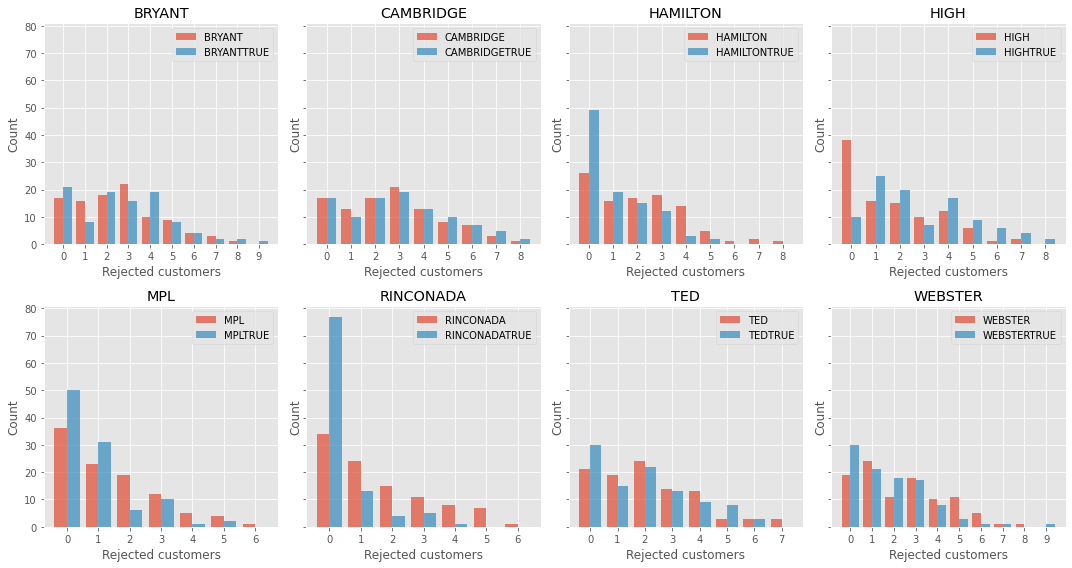

In [324]:
fig, axes = plt.subplots(nrows=2, ncols=len(df_out.columns)//4, figsize=(15, 8), sharey=True)

j = 0
p = 0
for i, (col1, col2) in enumerate(zip(df_out.columns[::2], df_out.columns[1::2])):
    #bins = np.arange(min(queue_length), max(queue_length) + 2) - 0.5

    bins = np.arange(df_out[[col1, col2]].min().min(), df_out[[col1, col2]].max().max() + 2) - 0.5

    ax = axes[j,p]
    ax.hist([df_out[col1], df_out[col2]], bins = bins, align='mid', rwidth=0.8, label=[col1, col2], alpha=0.7 )
    ax.set_title(f"{col1}")  # Set subplot title

    ax.set_xticks(range(int(df_out[[col1, col2]].min().min()), int(df_out[[col1, col2]].max().max() + 1)))

    ax.set_xlabel('Rejected customers')
    ax.set_ylabel('Count')


    ax.legend()  # Show legend

    if i == 3:
        j = 1
        p = 0
    else:
        p += 1

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [326]:
df_out.mean()

BRYANT           2.56
BRYANTTRUE       2.73
CAMBRIDGE        2.73
CAMBRIDGETRUE    2.96
HAMILTON         2.13
HAMILTONTRUE     1.07
HIGH             1.74
HIGHTRUE         2.79
MPL              1.43
MPLTRUE          0.87
RINCONADA        1.60
RINCONADATRUE    0.40
TED              2.15
TEDTRUE          1.92
WEBSTER          2.40
WEBSTERTRUE      1.77
dtype: float64

#### Queue length directly from data

In [231]:

run_name = '4favk84f_3'
folder_name = 'forecast_1_aware_tgcn_static_3/'

df_waittimes = queue_length_wait_times('../predictions/forecast_1_aware_tgcn_static_3/predictions_TGCN_WEBSTER_4favk84f_3.csv',
                                          cluster='WEBSTER', time_resolution='HourMinute', no_of_plugs=4)

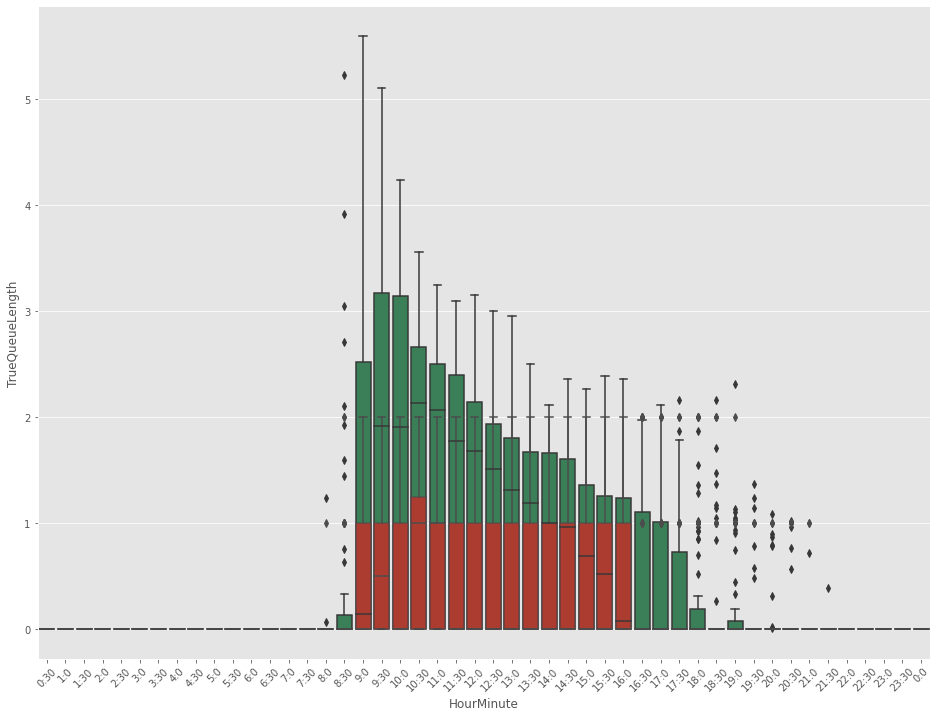

In [266]:
fig, axes = plt.subplots(1, figsize=(16,12))
sns.boxplot(data=df_waittimes, x="HourMinute", y="QueueLength", ax = axes, color="seagreen")
sns.boxplot(data=df_waittimes, x="HourMinute", y="TrueQueueLength", ax = axes, color="red", boxprops=dict(alpha=.7))
#sns.lineplot(data=df_waittimes.groupby('HourMinute').median().sort_values(by='Hour'), x="HourMinute", y="TrueQueueLength", ax = axes, color="blue")
plt.xticks(rotation=45)
plt.show()

In [290]:
## Extract table
index_time = ['0:0', '0:30', '10:0', '10:30', '11:0', '11:30', '12:0', '12:30',
       '13:0', '13:30', '14:0', '14:30', '15:0', '15:30', '16:0', '16:30',
       '17:0', '17:30', '18:0', '18:30', '19:0', '19:30', '1:0', '1:30',
       '20:0', '20:30', '21:0', '21:30', '22:0', '22:30', '23:0', '23:30',
       '2:0', '2:30', '3:0', '3:30', '4:0', '4:30', '5:0', '5:30', '6:0',
       '6:30', '7:0', '7:30', '8:0', '8:30', '9:0', '9:30']

df_cluster_ql = pd.DataFrame({'index_time': index_time})
df_cluster_diff = pd.DataFrame({'index_time': index_time})
c = 3
k = 0

for i in cluster_list:
    cl_name = cluster_names[k]
    reject_list = []
    print(cl_name)
    
    path = '../predictions/' + folder_name + i + '.csv'

    ## Create simulation datafram
    df_model_sim = queue_length_wait_times(path, cluster = cl_name, time_resolution='HourMinute', no_of_plugs=c)
    
    if k == 0:
        df_cluster_ql['HourIndex'] = df_model_sim.groupby('HourMinute').mean()['Hour'].values
        df_cluster_diff['HourIndex'] = df_model_sim.groupby('HourMinute').mean()['Hour'].values

    df_cluster_ql[cl_name + '_QL_MEAN'] = df_model_sim.groupby('HourMinute').mean()['QueueLength'].values
    df_cluster_ql[cl_name + '_QL_SD'] = df_model_sim.groupby('HourMinute').std()['QueueLength'].values

    df_cluster_ql[cl_name + '_TRUE_QL_MEAN'] = df_model_sim.groupby('HourMinute').mean()['TrueQueueLength'].values
    df_cluster_ql[cl_name + '_TRUE_QL_SD'] = df_model_sim.groupby('HourMinute').std()['TrueQueueLength'].values


    df_cluster_diff[cl_name + '_QL_MEAN_DIFF'] = df_model_sim.groupby('HourMinute').mean()['QueueLength'].values - df_model_sim.groupby('HourMinute').mean()['TrueQueueLength'].values

    k += 1


BRYANT
CAMBRIDGE
HAMILTON
HIGH
MPL
RINCONADA
TED
WEBSTER


In [295]:
df_cluster_ql = df_cluster_ql.sort_values(by=['HourIndex', 'index_time']).reset_index(drop=True)
df_cluster_diff = df_cluster_diff.sort_values(by=['HourIndex', 'index_time']).reset_index(drop=True)

time_ranges = [
    ('12:00 AM - 6:00 AM', range(0, 6)),
    ('6:00 AM - 12:00 PM', range(6, 12)),
    ('12:00 PM - 6:00 PM', range(12, 18)),
    ('6:00 PM - 12:00 AM', range(18, 25))
]

# Create an empty DataFrame to store the aggregated results
df_resampled = pd.DataFrame(columns=df_cluster_diff.columns)

# Aggregate the DataFrame into 6-hour groups
for label, hour_range in time_ranges:
    group_data = df_cluster_diff[df_cluster_diff.HourIndex.isin(hour_range)].mean()  # Calculate the mean for each column in the group
    df_resampled.loc[label] = group_data

# Drop index_time
df_resampled = df_resampled.drop(columns='index_time')
print(np.round(df_resampled,2).to_latex())

                    index_time  HourIndex  BRYANT_QL_MEAN_DIFF  \
12:00 AM - 6:00 AM         NaN        2.5             0.000000   
6:00 AM - 12:00 PM         NaN        8.5            -0.516608   
12:00 PM - 6:00 PM         NaN       14.5            -0.935874   
6:00 PM - 12:00 AM         NaN       20.5            -0.380103   

                    CAMBRIDGE_QL_MEAN_DIFF  HAMILTON_QL_MEAN_DIFF  \
12:00 AM - 6:00 AM                0.000000               0.000000   
6:00 AM - 12:00 PM               -0.550378               0.253864   
12:00 PM - 6:00 PM               -1.458637               0.397509   
6:00 PM - 12:00 AM               -0.304296               0.088515   

                    HIGH_QL_MEAN_DIFF  MPL_QL_MEAN_DIFF  \
12:00 AM - 6:00 AM           0.000000          0.000000   
6:00 AM - 12:00 PM           1.141289          0.138574   
12:00 PM - 6:00 PM           1.014992          0.119084   
6:00 PM - 12:00 AM           0.653462          0.028056   

                    RINCONA

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_43124/887274875.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  group_data = df_cluster_diff[df_cluster_diff.HourIndex.isin(hour_range)].mean()  # Calculate the mean for each column in the group
